#  Clustering

## Objectives
1. K-means
2. K-means++
3. Hierarchical clustering
4. DBSCAN
____

### K-means
K-means is an unsupervised ML technique to cluster unlabeled dataset to k clusters where each datapoint belongs to a cluster with the nearest centroid.
##### Thoughts:
What's the pros and cons of K-means?

<span style="color:blue">
Pros:

1. Scales good with large datasets
2. Guarantees convergence.
3. generalize well with clusters of globular, spherical,or elliptical shapes.

Cons:
1. K has to be chosen manually. (we can use the loss vs the #cluster method)
2. Being dependent on the initial state
3. Not efficient at clustering data with varying densities and sizes.
4. It doesn't scale good when the number of dimensions gets so big as the distance metric will converge to a constant value between any given examples.
(so we may need to reduce dimensions first)

#### Data generation

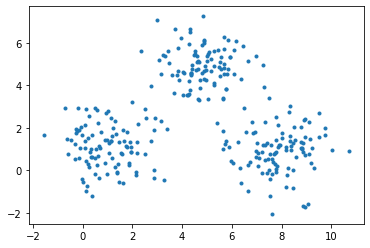

In [1]:
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt

real_centers = [[1,1], [5,5], [8, 1]]
X, y = make_blobs(n_samples=300, centers=real_centers, n_features=2,
                   random_state=0,)

plt.scatter(X[:,0], X[:,1], marker='.')

#### Implement K-means
Task: implement the fit and predict function of K-means class here.

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.spatial.distance import cdist
from copy import deepcopy

class KMeans(BaseEstimator, ClassifierMixin):

    def __init__(self, k=3, centers=None):
        self.k = k
        self.centers = centers

    def _predict(self, X, centers):
        # (1 line) Calculate the pairwise distance
        # between each sample in X and the centroids.
        distances = cdist(X, centers)
        return np.argmin(distances, axis=1)

    def predict(self, X, y=None):
        return self._predict(X, self.centers)

    def fit(self, X, y=None):
        k = self.k
        c = X.shape[1]
        if self.centers is None:
            mean = np.mean(X, axis = 0)
            std = np.std(X, axis = 0)
            self.centers = np.random.randn(k, c) * std + mean
        centers = self.centers
        centers_new = deepcopy(self.centers) # Store new centers

        error = -1

        # When, after an update, the estimate of that center stays the same, exit loop
        while error != 0:
            # Predict clusters of each point using the current clusters
            clusters = self._predict(X, centers)
            centers_old = deepcopy(centers_new)
            # Calculate mean for every cluster and update the center in 'centers_new'
            for i in range(k):
                centers_new[i] = np.mean(X[clusters == i], axis=0)

            error = np.linalg.norm(centers_new - centers_old)
            centers = centers_new
        self.centers = centers_new
        return self

    def score(self, X, y=None):
        return 0


Train and predict K-means model on the generated dataset.

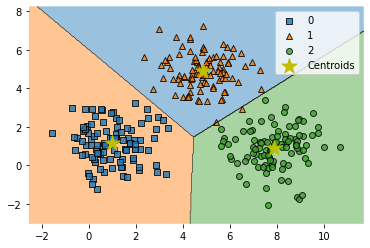

In [4]:
from mlxtend.plotting import plot_decision_regions

clf = KMeans(3, None).fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250,label='Centroids')
plt.legend()

### K-Means++

This algorithm is made to solve the problem of initial centroids values.

K-means++
1. Choose one center uniformly at random from among the data points.
2. For each data point x, compute $D(x)$.
3. Choose the next centroid using a weighted probability distribution where a point x is chosen with probability proportional to  $𝐷(𝑥)^2$ .
4. Repeat until you have k points.

$D(x)$: the distance betweem x and the closest center

-----
Task: Implement K-means++ algorithm for selecting the intial points.

In [5]:
from numpy.random import choice


def choose(X, prob):
    # Return one point of X chosen randomly with probablity p
    # USE choise function in np.random (3 lines):
    n = X.shape[0]
    idx = choice(n, 1, p=prob)
    return X[idx]

def kmeans_pp(X, k):
    n = X.shape[0]
    weights = np.ones(n) / n
    centers = []
    while len(centers) < k:
        # Choose a centroid with the current weights
        centroid = choose(X, weights)
        centers.extend(centroid)
        # Calculate the pair-wise distances
        # between the datapoints X and the current centers
        # get min distance then square it.
        # Obtain new probabilities in weights.
        distances = cdist(X, centers)
        min_distance = np.min(distances, axis=1)
        d_squared = min_distance ** 2
        weights = d_squared / d_squared.sum()

    return np.array(centers)

initial_centers = kmeans_pp(X, 3)

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not R

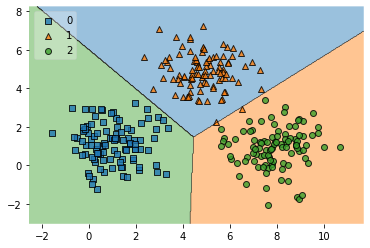

In [7]:
clf = KMeans(3, None).fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.scatter(initial_centers[:,0], initial_centers[:,1], marker='*', c='R', s=250,label='Init centers')
plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250,label='Centroids')
plt.legend()

## How to choose k

Elbow method:

One way is to plot the sum of squared distances of samples to their centeriods vs number of clusters K.
Then, choose the K which the error doesn't decrease too much after.

In [8]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

ModuleNotFoundError: No module named 'sklearn.datasets.samples_generator'

In [9]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

TypeError: __init__() got an unexpected keyword argument 'n_clusters'

Another way is to measure the silhouette score for the clustering.
This score measures the separability between clusters and the cohesion inside the clusters.

Then, we take the K that has higher score.

In [10]:
from sklearn.metrics import silhouette_score
silhouettes = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    y = kmeans.predict(X)
    score = silhouette_score(X, y)
    silhouettes.append(score)
plt.plot(range(2, 11), silhouettes)
plt.title('silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.show()

TypeError: __init__() got an unexpected keyword argument 'n_clusters'

In [11]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,0], X[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

TypeError: __init__() got an unexpected keyword argument 'n_clusters'

### Hierarchical Clustering

We will compare between different types of linkage algorithm in different datasets.

#### Differences between Hierarchical clustering and KMeans:
1. Each run of KMeans on the same data is different, but in HC will be the same.
2. For hyper-spherical clusters shape, k-means works better.
3. Time complexity is proportional to the square of #points in HC while K-Means is linearly proportional.

---
#### Data generation

In [12]:
import time
import warnings

import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)


<Figure size 986.4x1044 with 0 Axes>

Trying different types of linkage algorithms in Agglomerative Hierarchical Clustering


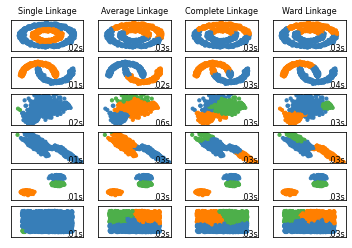

In [13]:
plot_num = 1

default_base = {'n_clusters': 3}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {}),
    (aniso, {}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    complete = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete')
    average = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average')
    single = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18, fontsize=8)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right', fontsize=8)
        plot_num += 1

plt.show()


### DBSCAN

What's the pros and cons of DBSCAN?

<span style="color:blue">
Pros:

1. Discovers arbitray shapes clusters
2. Robust towards outliers/noise

Cons:
1. Not efficient at clustering data with varying densities and sizes.
2. Sensitive to clustering params: minPoints & EPS
3. It doesn't scale good when the number of dimensions gets so big as the distance metric will converge to a constant value between any given examples.

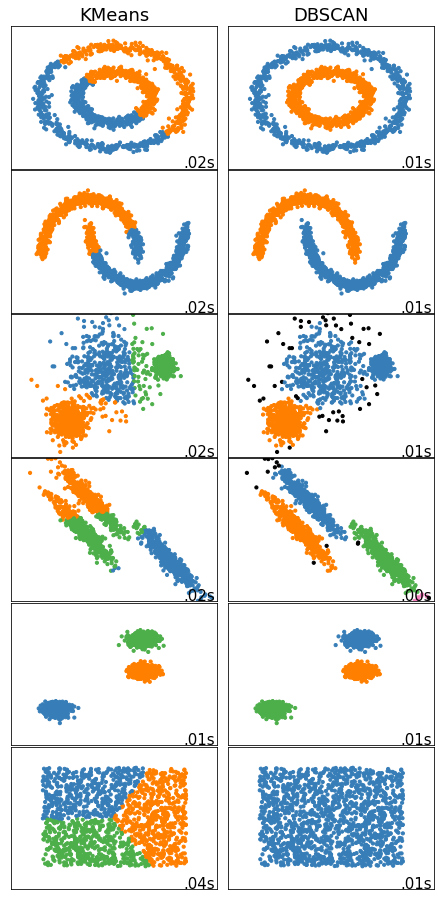

In [14]:
from sklearn.neighbors import kneighbors_graph

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,

                'n_neighbors': 10,
                'n_clusters': 3,
                }

datasets = [
    (noisy_circles, {'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.KMeans(n_clusters=params['n_clusters'])
    dbscan = cluster.DBSCAN(eps=params['eps'])

    clustering_algorithms = (
        ('KMeans', ms),
        ('DBSCAN', dbscan),

    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right'
                )
        plot_num += 1

plt.subplots_adjust(right=0.3)
plt.show()